<div style="background-color: yellow; padding: 18px;">
    <h1> Data Science Challenge |  Data & Analytics Team
</div>

<div style="background-color: lightblue; padding: 10px;">
    <h2> Case 3 - Previsión de falla
</div>
    

**Descripción**
 
Los galpones de Full de mercado libre cuentan con una flota de dispositivos que transmiten diariamente telemetría agregada en varios atributos.

Las técnicas de mantenimiento predictivo están diseñadas para ayudar a determinar la condición del equipo de mantenimiento en servicio para predecir cuándo se debe realizar el mantenimiento. Este enfoque promete ahorros de costos sobre el mantenimiento preventivo de rutina o basado en el tiempo porque las tareas se realizan solo cuando están justificadas.
   
Tiene la tarea de generar una Jupyter notebook con un modelo predictivo para predecir la probabilidad de falla del dispositivo con el objetivo de bajar los costos del proceso. Como una referencia, una falla de un dispositivo tiene un costo de 1 mientras el costo de un mantenimiento es 0,5. El archivo "full_devices.csv" tiene los valores diários para los 9 atributos de los dispositivos y la columna que está tratando de predecir se llama 'failure' con el valor binario 0 para no fallar y 1 para fallar.
    
___

# Estratégia adotada:

- Analisar os dados para definir estratégia de implementação
- Pré processamento de dados
    - Feature Engineering e preparação dos dados
- Criar modelos
- Avaliar os modelos
- Balancear classes
    - Resampling 
- Otimizar hiper parâmetros do modelo com função custo personalizada
- Calcular custo
- Conclusão

## Carregar, analisar e limpar os dados

In [1]:
# Importando as bibliotecas necessárias

import numpy as np
import pandas as pd
import datetime as dt

import matplotlib.pyplot as plt
import seaborn as sns

# import plotly.express as px
# from plotly.offline import init_notebook_mode, iplot

from sklearn.metrics import (ConfusionMatrixDisplay, classification_report, precision_recall_curve, 
                             PrecisionRecallDisplay, RocCurveDisplay,
                             recall_score, make_scorer, roc_auc_score)

In [2]:
# Carregando base de dados. Precisei colocar o encoding

df = pd.read_csv("files/full_devices.csv", encoding="latin1")

In [3]:
df

,date,device,failure,attribute1,attribute2,attribute3,attribute4,attribute5,attribute6,attribute7,attribute8,attribute9
0,2015-01-01,S1F01085,0,215630672,56,0,52,6,407438,0,0,7
1,2015-01-01,S1F0166B,0,61370680,0,3,0,6,403174,0,0,0
2,2015-01-01,S1F01E6Y,0,173295968,0,0,0,12,237394,0,0,0
3,2015-01-01,S1F01JE0,0,79694024,0,0,0,6,410186,0,0,0
4,2015-01-01,S1F01R2B,0,135970480,0,0,0,15,313173,0,0,3
...,...,...,...,...,...,...,...,...,...,...,...,...
124489,2015-11-02,Z1F0MA1S,0,18310224,0,0,0,10,353705,8,8,0
124490,2015-11-02,Z1F0Q8RT,0,172556680,96,107,4,11,332792,0,0,13
124491,2015-11-02,Z1F0QK05,0,19029120,4832,0,0,11,350410,0,0,0
124492,2015-11-02,Z1F0QL3N,0,226953408,0,0,0,12,358980,0,0,0


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 124494 entries, 0 to 124493
Data columns (total 12 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   date        124494 non-null  object
 1   device      124494 non-null  object
 2   failure     124494 non-null  int64 
 3   attribute1  124494 non-null  int64 
 4   attribute2  124494 non-null  int64 
 5   attribute3  124494 non-null  int64 
 6   attribute4  124494 non-null  int64 
 7   attribute5  124494 non-null  int64 
 8   attribute6  124494 non-null  int64 
 9   attribute7  124494 non-null  int64 
 10  attribute8  124494 non-null  int64 
 11  attribute9  124494 non-null  int64 
dtypes: int64(10), object(2)
memory usage: 11.4+ MB


In [5]:
# Analisar basicamente algumas estatísticas das features numéricas
df.describe()

,failure,attribute1,attribute2,attribute3,attribute4,attribute5,attribute6,attribute7,attribute8,attribute9
count,124494.000000,1.244940e+05,124494.000000,124494.000000,124494.000000,124494.000000,124494.000000,124494.000000,124494.000000,124494.000000
mean,0.000851,1.223881e+08,159.484762,9.940455,1.741120,14.222669,260172.657726,0.292528,0.292528,12.451524
std,0.029167,7.045933e+07,2179.657730,185.747321,22.908507,15.943028,99151.078547,7.436924,7.436924,191.425623
min,0.000000,0.000000e+00,0.000000,0.000000,0.000000,1.000000,8.000000,0.000000,0.000000,0.000000
25%,0.000000,6.128476e+07,0.000000,0.000000,0.000000,8.000000,221452.000000,0.000000,0.000000,0.000000
50%,0.000000,1.227974e+08,0.000000,0.000000,0.000000,10.000000,249799.500000,0.000000,0.000000,0.000000
75%,0.000000,1.833096e+08,0.000000,0.000000,0.000000,12.000000,310266.000000,0.000000,0.000000,0.000000
max,1.000000,2.441405e+08,64968.000000,24929.000000,1666.000000,98.000000,689161.000000,832.000000,832.000000,18701.000000


Os atributos tem escalas diferentes. Se usarmos modelos baseados em distância, será necessário normalizar/padronizar os atributos

In [6]:
# Analisar basicamente algumas estatísticas das features categóricas
df.describe(include='O')

,date,device
count,124494,124494
unique,304,1169
top,2015-01-01,Z1F0QLC1
freq,1163,304


In [7]:
# tirar duplicados # 1 registro
df = df.drop_duplicates()

In [8]:
# verificar se tem dados faltantes
df.isna().sum()

date          0
device        0
failure       0
attribute1    0
attribute2    0
attribute3    0
attribute4    0
attribute5    0
attribute6    0
attribute7    0
attribute8    0
attribute9    0
dtype: int64

In [9]:
# Período de tempo
df.date.min(), df.date.max()

('2015-01-01', '2015-11-02')

In [10]:
# target - falha
df.failure.value_counts(dropna=False)

failure
0    124387
1       106
Name: count, dtype: int64

In [11]:
print(f"Dados referentes ao período de tempo entre {df.date.min()} e {df.date.max()}")

print(f"{len(df)} registros de {df.device.nunique()
                                 } devices em {df.date.nunique()} dias distintos")
print(f"São {df.failure.value_counts(dropna=False)[1]} falhas, o que significa {
      round(df.failure.value_counts(dropna=False, normalize=True)[1]*100, 4)}% do casos")

Dados referentes ao período de tempo entre 2015-01-01 e 2015-11-02
124493 registros de 1169 devices em 304 dias distintos
São 106 falhas, o que significa 0.0851% do casos


In [12]:
# Arrumando o índice
df = df.reset_index(drop=True)

**Desequilíbrio entre as classes da variável target, failure - desbalanceamento significativo**

In [13]:
# Transformando a data em datetime e colocando como índice para facilitar a visualização

df['date'] = pd.to_datetime(df['date'])
df = df.set_index('date').sort_index()

In [14]:
df

,device,failure,attribute1,attribute2,attribute3,attribute4,attribute5,attribute6,attribute7,attribute8,attribute9
date,,,,,,,,,,,
2015-01-01,S1F01085,0,215630672,56,0,52,6,407438,0,0,7
2015-01-01,S1F0166B,0,61370680,0,3,0,6,403174,0,0,0
2015-01-01,S1F01E6Y,0,173295968,0,0,0,12,237394,0,0,0
2015-01-01,S1F01JE0,0,79694024,0,0,0,6,410186,0,0,0
2015-01-01,S1F01R2B,0,135970480,0,0,0,15,313173,0,0,3
...,...,...,...,...,...,...,...,...,...,...,...
2015-11-02,Z1F0MA1S,0,18310224,0,0,0,10,353705,8,8,0
2015-11-02,Z1F0Q8RT,0,172556680,96,107,4,11,332792,0,0,13
2015-11-02,Z1F0QK05,0,19029120,4832,0,0,11,350410,0,0,0


In [15]:
attributes = [col for col in df.columns if 'attribute' in col]

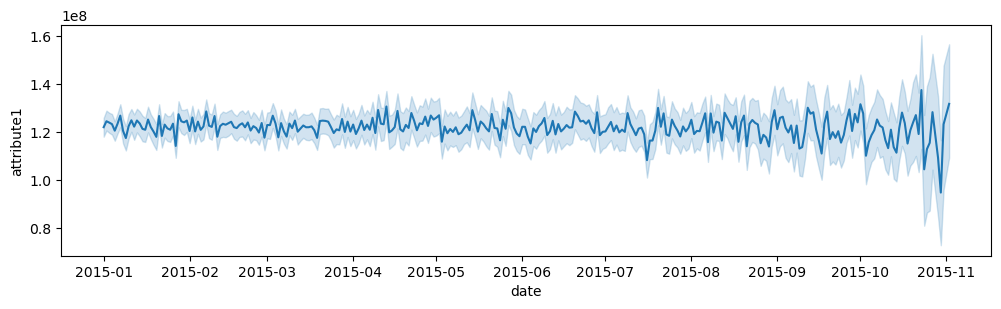

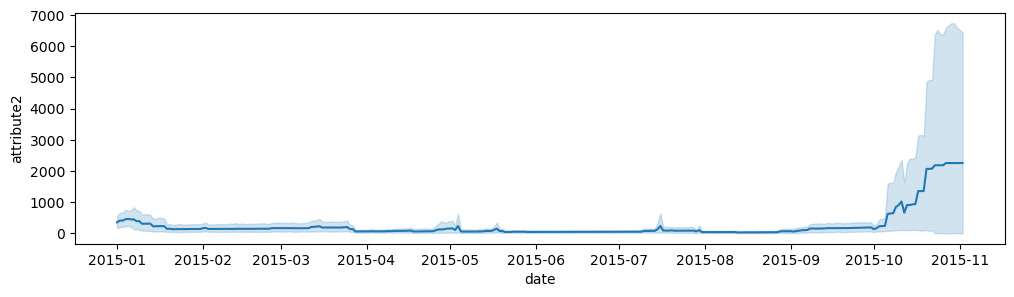

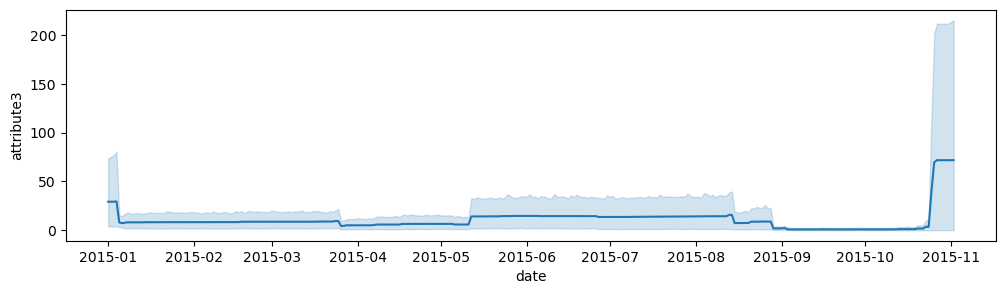

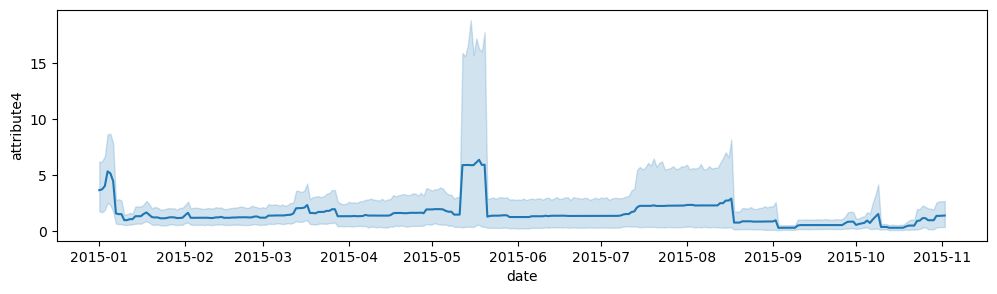

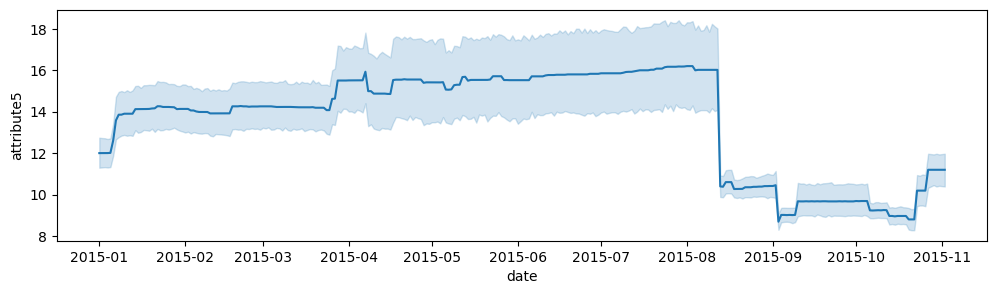

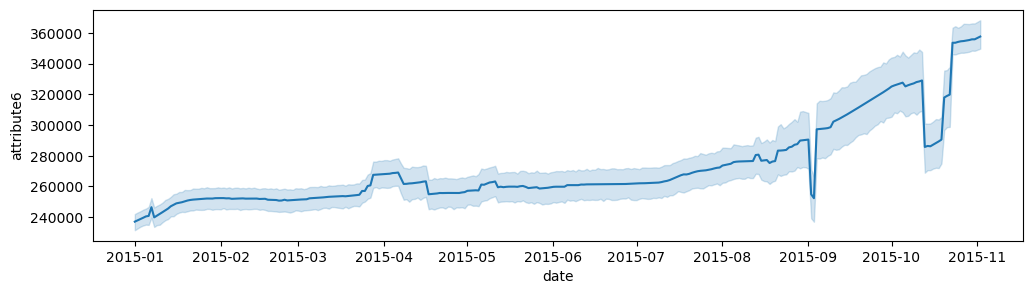

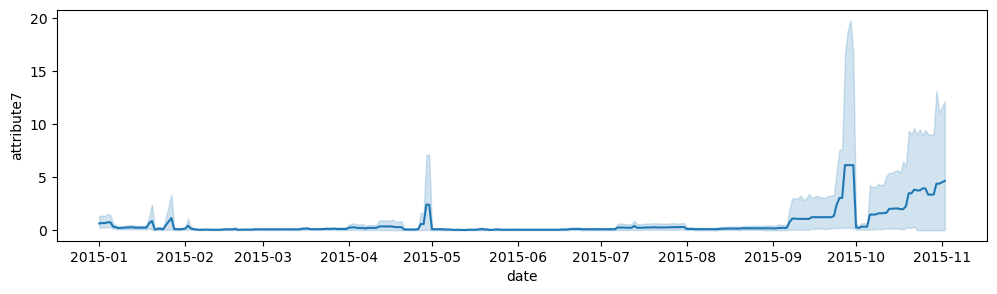

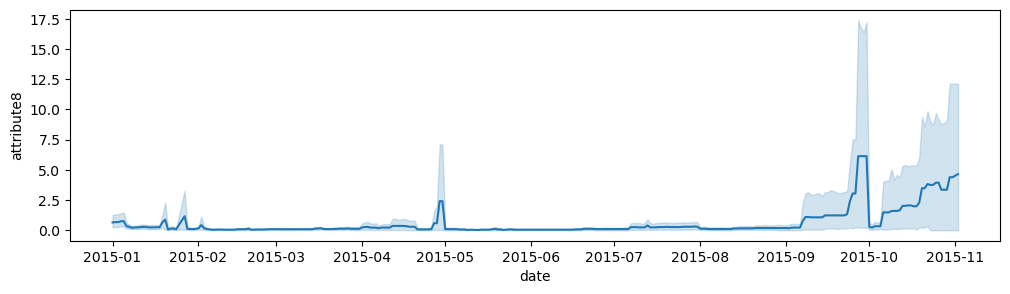

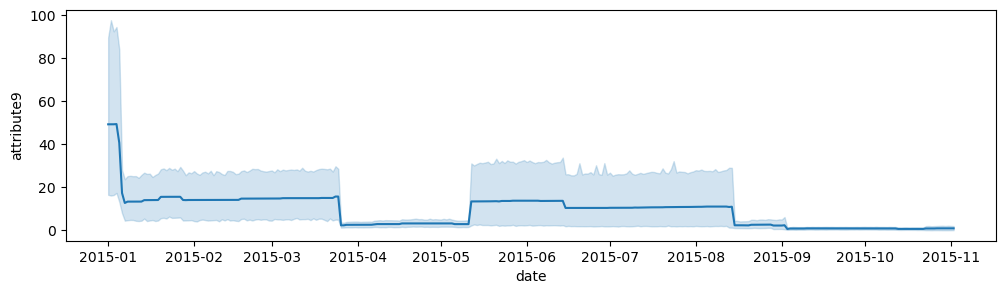

In [16]:
# Visualizar o comportamento de cada atributo ao longo do tempo
# Lineplot agrega valores repetidos e mostra a média e o intervalo de confiança

for col in attributes:

    plt.figure(figsize=(12, 3))

    sns.lineplot(data=df, x=df.index, y=col)

    plt.show()

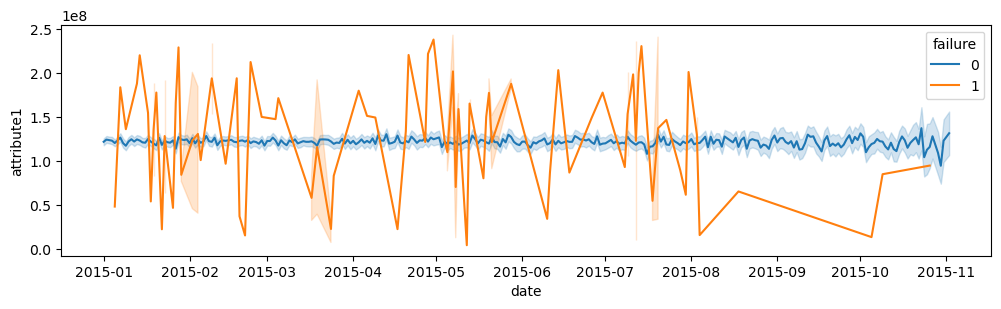

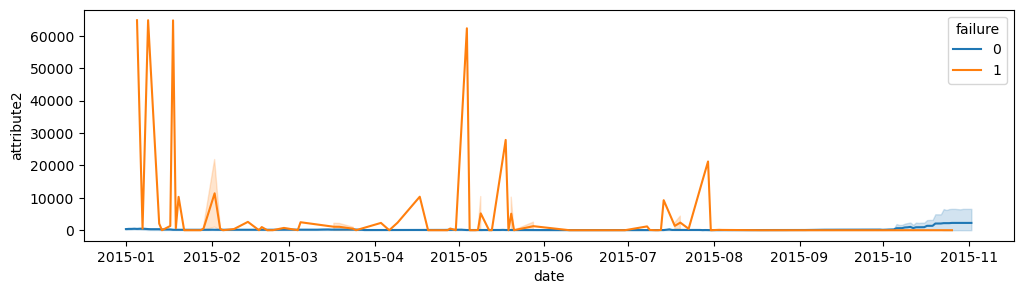

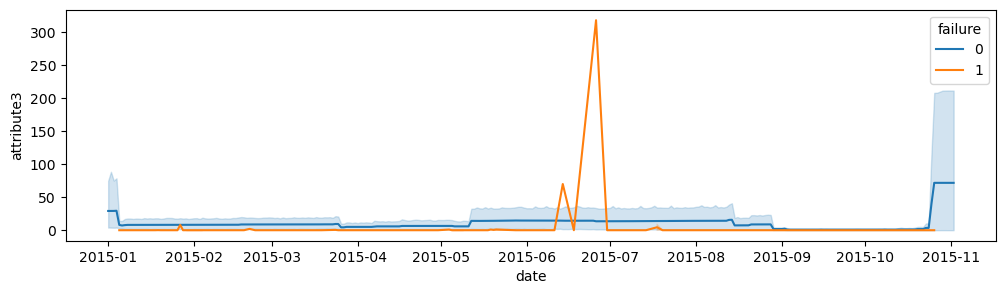

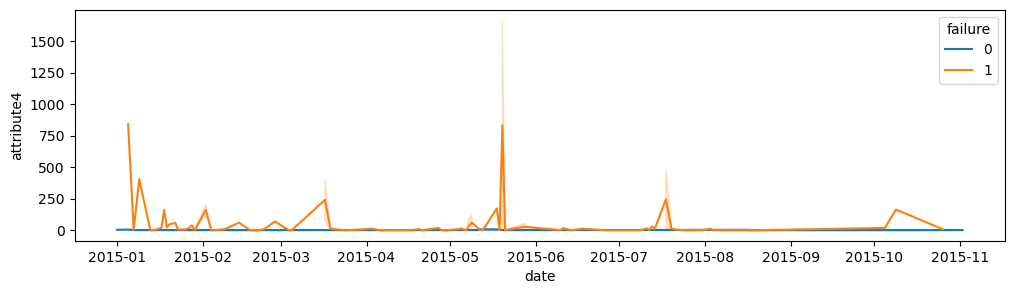

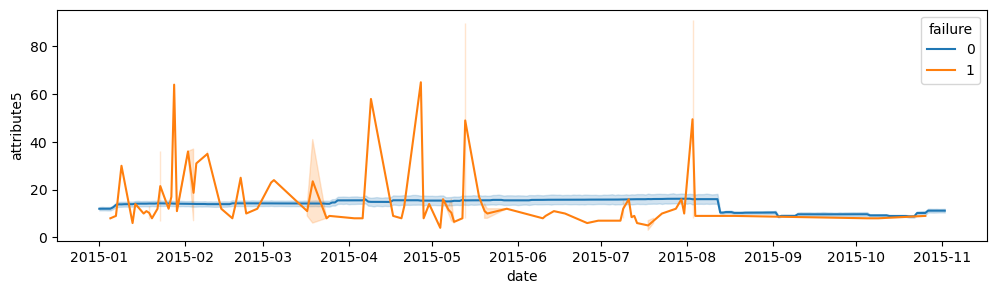

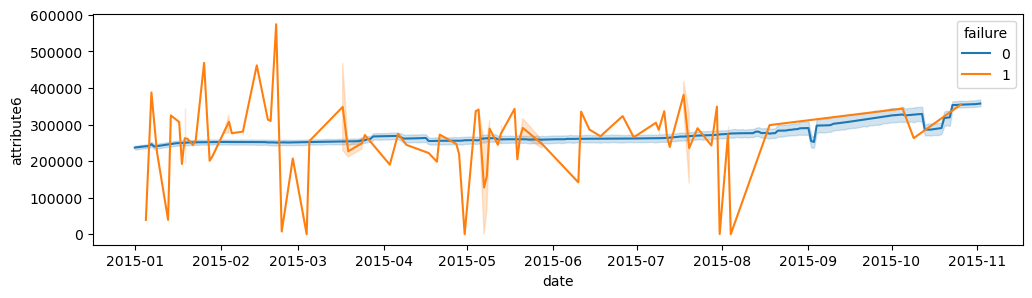

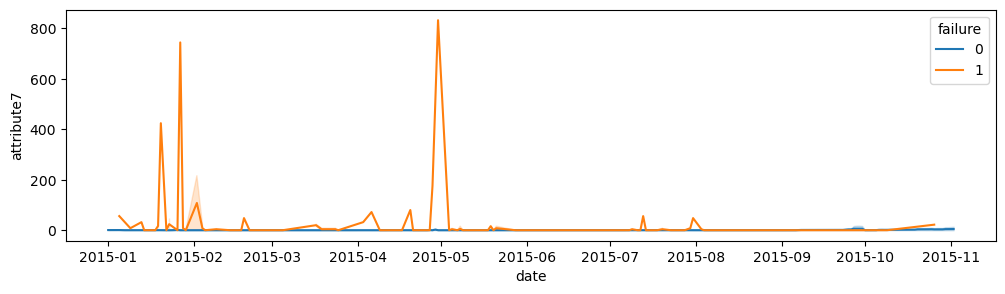

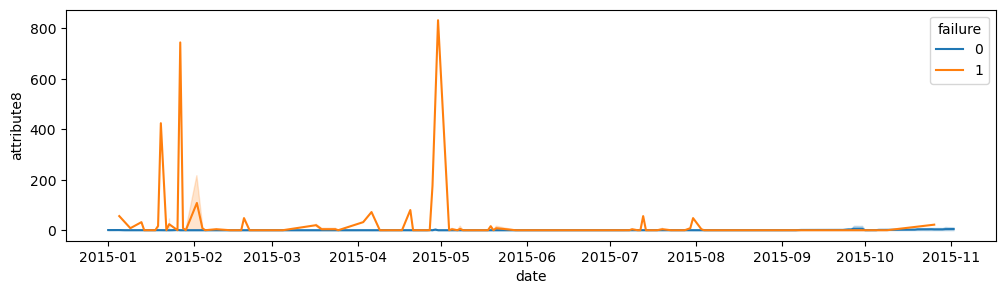

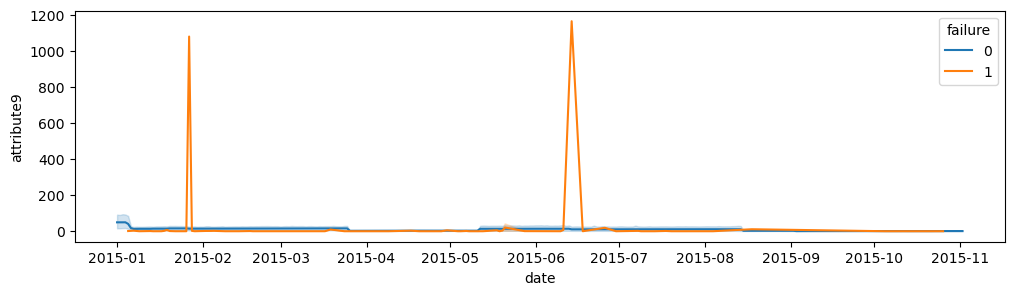

In [17]:
# Adicionando o target como parâmetro hue

for col in attributes:

    plt.figure(figsize=(12, 3))

    sns.lineplot(data=df, x=df.index, y=col, hue="failure")

    plt.show()

- Analisando os devices com as falhas

In [18]:
df['device'].nunique()

1169

In [19]:
df['device'].value_counts()

device
Z1F0QLC1    304
S1F0KYCR    304
S1F0E9EP    304
S1F0EGMT    304
S1F0FGBQ    304
           ... 
W1F1CHZK      5
W1F1CJKT      5
S1F04KSC      4
W1F0WJFT      3
W1F1DA5ÿ      1
Name: count, Length: 1169, dtype: int64

<Axes: xlabel='count', ylabel='Count'>

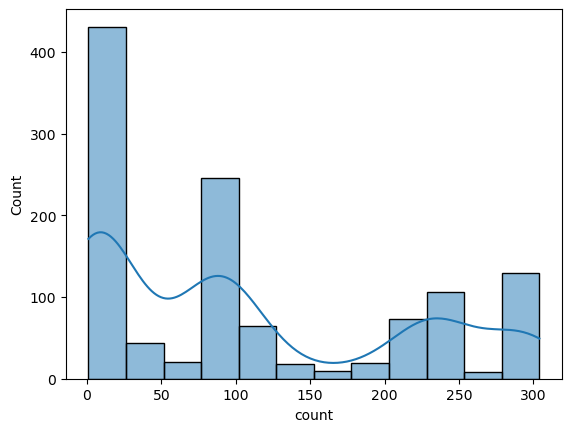

In [20]:
sns.histplot(df['device'].value_counts(), kde=True)

Aparentemente apenas alguns devices o registro de  falha

In [21]:
group_device_mean_failure = df.groupby(['device'])[['failure']].mean()

In [22]:
# Devices que não apresentaram nenhuma falha

group_device_mean_failure[group_device_mean_failure['failure'] ==
                          0].shape[0] / group_device_mean_failure.shape[0]

0.9093242087254063

In [23]:
# Devices que só apresentaram falha

group_device_mean_failure[group_device_mean_failure['failure'] ==
                          1].shape[0] / group_device_mean_failure.shape[0]

0.0

In [24]:
# Devices que não apresentaram falhas mas que também apresentaram (ambos, falha e não falha)

group_device_mean_failure[~(group_device_mean_failure['failure'].isin([0, 1])
                            )].shape[0] / group_device_mean_failure.shape[0]

0.09067579127459367

Então não dá para tratar os devices separadamente.

***Este não é um problema de série temporal no sentido de que exige um modelo autorregressivo ou de sequência.***

Em vez disso, formularemos o problema como uma tarefa de classificação.

No entanto, faremos uma validação fora do tempo (out-of-time validation), dada a dimensão temporal (ordem cronológica dos dados)

## Pré processamento dos dados

In [25]:
# Selecionando as features e target do problema

X = df[attributes]
y = df['failure']

Particionando os dados (de forma manual, sem usar o scikit-learn

In [26]:
train_perc = 0.7
split_index = int(train_perc * X.shape[0])

end_date_train = X.index[split_index]

# começando o test na data seguinte
unique_days = X.index.unique().tolist()
start_date_test = unique_days[unique_days.index(end_date_train) + 1]

end_date_train, start_date_test

(Timestamp('2015-05-30 00:00:00'), Timestamp('2015-05-31 00:00:00'))

In [27]:
X_train, X_test = X.loc[:end_date_train], X.loc[start_date_test:]
y_train, y_test = y.loc[:end_date_train], y.loc[start_date_test:]

In [28]:
X_train.index.min(), X_train.index.max()

(Timestamp('2015-01-01 00:00:00'), Timestamp('2015-05-30 00:00:00'))

In [29]:
X_test.index.min(), X_test.index.max()

(Timestamp('2015-05-31 00:00:00'), Timestamp('2015-11-02 00:00:00'))

In [30]:
# ajustando a proporção, deve ser aproximadamente 70/30

X_train.shape[0] / X.shape[0], X_test.shape[0] / X.shape[0]

(0.7017181688930302, 0.2982818311069699)

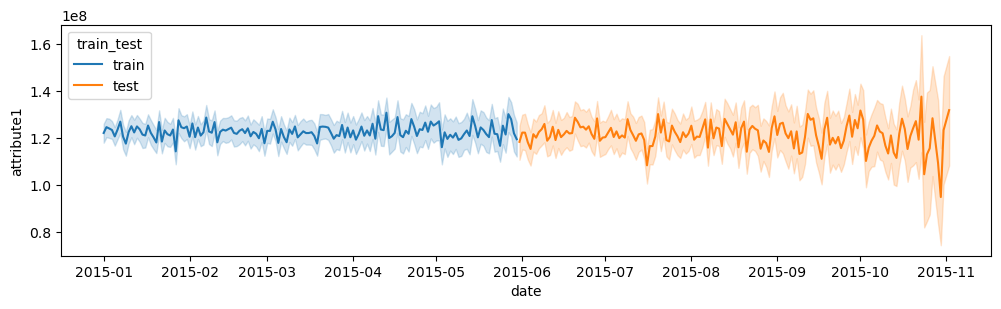

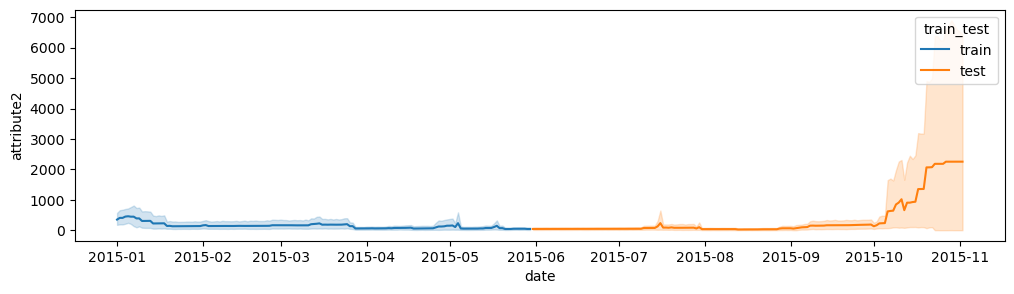

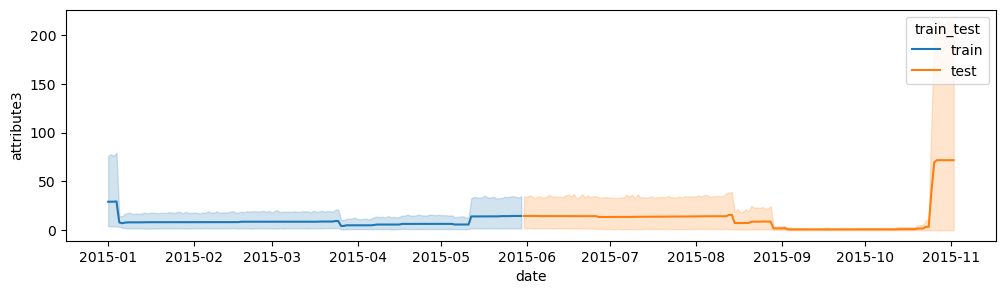

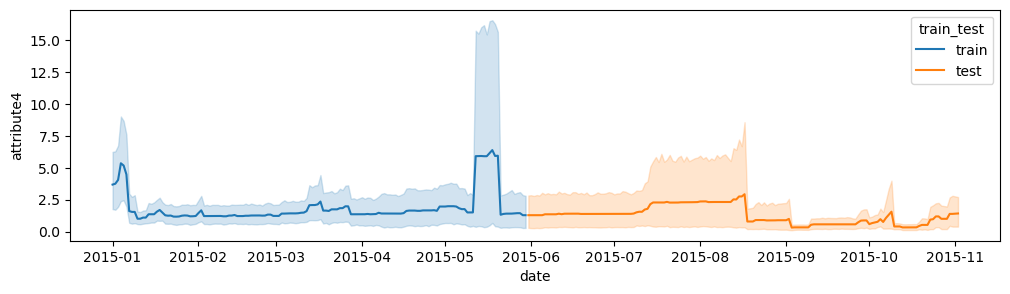

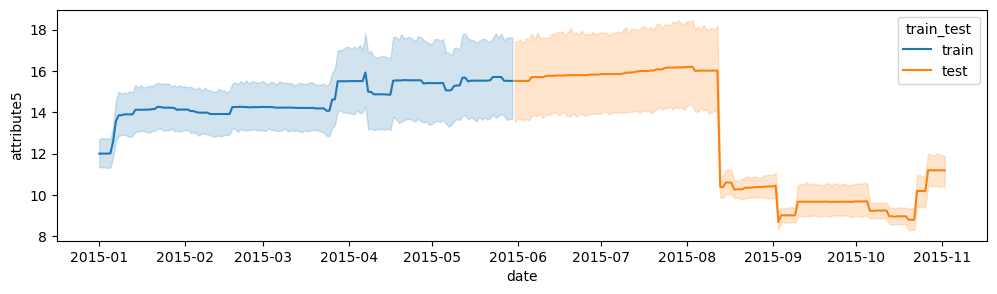

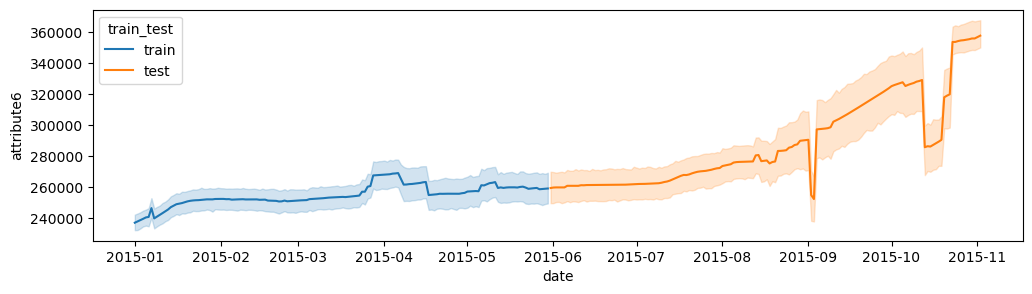

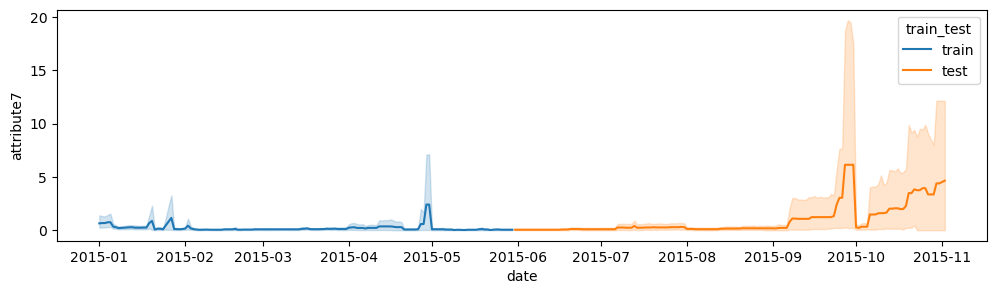

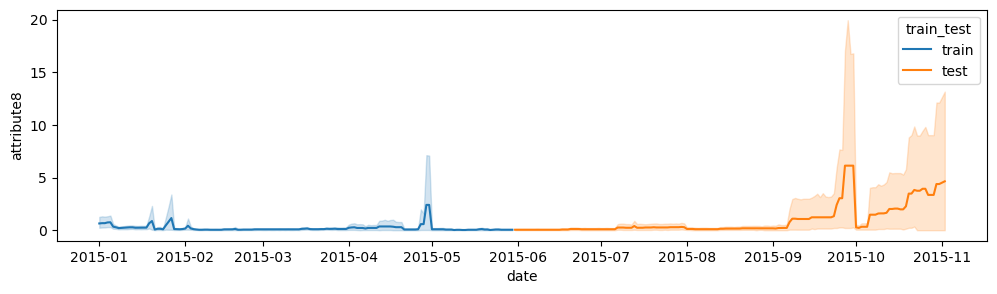

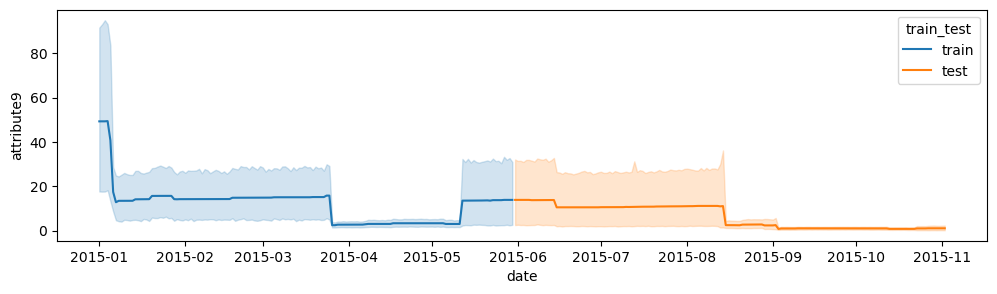

In [31]:
# Visualizando o split treino e teste

aux = df.copy()
aux.loc[:end_date_train, "train_test"] = "train"
aux.loc[start_date_test:, "train_test"] = "test"

for col in attributes:
    
    plt.figure(figsize=(12, 3))
    
    sns.lineplot(data=aux, x=aux.index, y=col, hue="train_test")
    
    plt.show()

É estranho que a divisão entre treino e teste seja, em quantidade de observações, 70/30, mas no tempo é metade/metade do ano: veja, 70% dos dados vão de janeiro até o final de maio - isso significa que na segunda metade do ano há menos dados. Portanto, é apropriado usá-lo como teste.

## Criação, desenvolvimento  e avaliação do modelo

In [32]:
# Funções de avaliação do modelo de classificação 

def calc_f1_score(p, r):
    
    return 2/((1/p) + (1/r))

def plot_prec_rec_f1_curve(y_real, proba, pos_label=None):

    precisions, recalls, cutoffs = precision_recall_curve(y_real, proba, pos_label=pos_label)
    
    f1_scores = calc_f1_score(precisions[:-1], recalls[:-1])
    
    plt.title("Precision-recall tradeoff")

    plt.plot(cutoffs, precisions[:-1], label="precision")
    plt.plot(cutoffs, recalls[:-1], label="recall")
    plt.plot(cutoffs, f1_scores, label="f1 score")

    plt.xlabel("Cutoffs")

    plt.legend()
    plt.show()
    
def clf_metrics(modelo, X, y, cutoff=0.5, label_metrica="", 
                print_plot=True, plot_conf_matrix=True, print_cr=True,
                plot_prc=False, plot_roc=False, pos_label=None):
    
    classes = modelo.classes_
    n_classes = len(classes)
    
    if n_classes == 2:

        classes = modelo.classes_.tolist()

        idx_classe_positiva = classes.index(pos_label)

        probas = modelo.predict_proba(X)[:, idx_classe_positiva]

        classes.remove(pos_label)

        y_pred = np.where(probas >= cutoff, pos_label, classes[0])
    
    else:
        probas_all = modelo.predict_proba(X)
        y_pred = classes[probas_all.argmax(axis=1)]
        
    if print_plot:
        
        if n_classes == 2:
            print(f"{label_metrica} metrics - cutoff = {cutoff:.2f}")
        
        else:
            print(f"{label_metrica} metrics")
            
        if plot_conf_matrix:
            f,ax = plt.subplots(1,1,figsize=(4,4))
            ConfusionMatrixDisplay.from_predictions(y, y_pred, ax=ax)
            plt.show()
    
        if print_cr:
            print(classification_report(y, y_pred))
        
        if n_classes == 2:
            
            if plot_prc or plot_roc:
                print("="*80)
                print("cutoff-varying metrics".center(80))
                print(f"positive class: {pos_label}".center(80))
                print("="*80)

            if plot_prc:
                f,ax = plt.subplots(1,1,figsize=(4,4))
                PrecisionRecallDisplay.from_predictions(y, probas, pos_label=pos_label, ax=ax)
                plt.show()

                plot_prec_rec_f1_curve(y, probas, pos_label=pos_label)

            if plot_roc:
                f,ax = plt.subplots(1,1,figsize=(4,4))
                disp = RocCurveDisplay.from_predictions(y, probas, pos_label=pos_label, ax=ax)
                disp.ax_.set_title(f"AUC: {roc_auc_score(y, probas):.3f}", fontsize=16)

                x = np.linspace(0, 1, 2)
                plt.plot(x, x, color="k", ls=":")

                plt.show()
    
    return classification_report(y, y_pred, output_dict=True)

def clf_metrics_train_test(modelo, X_train, y_train, X_test, y_test, cutoff=0.5, 
                           print_plot=True, plot_conf_matrix=True, print_cr=True,
                           plot_prc=False, plot_roc=False, pos_label=None):

    cr_train = clf_metrics(modelo, X_train, y_train, cutoff=cutoff, label_metrica="train", 
                           print_plot=print_plot, plot_conf_matrix=plot_conf_matrix, print_cr=print_cr,
                           plot_prc=plot_prc, plot_roc=plot_roc, pos_label=pos_label)

    print()
    print("#"*80)
    print()

    cr_test = clf_metrics(modelo, X_test, y_test, cutoff=cutoff, label_metrica="test", 
                          print_plot=print_plot, plot_conf_matrix=plot_conf_matrix, print_cr=print_cr,
                          plot_prc=plot_prc, plot_roc=plot_roc, pos_label=pos_label)
    
    return cr_train, cr_test

In [33]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler, StandardScaler

Para avaliar o desempenho de um modelo de classificação, pode-se usar a matriz de confusão. Inclusive nesse caso fica fácil de validar pois é uma classificação binária, teve ou não teve falha.

Alguns pontos são importantes para avaliar:
- É comparado o modelo de teste e o modelo de treino parar ver se o modelo consegue generalizar
    - como ele se comporta com dados não vistos
- Evitar overfitting
    - basicamente igual a generalização. Evitar que o modelo se ajuste excessivamente aos detalhes específicos dos dados de treinamento, perdendo a capacidade de generalização.

Na matriz de confusão:

- Avaliação global do desempenho
    - Avalia a qualidade geral das previsões do modelo com verdadeiros positivos (TP), falsos positivos (FP), verdadeiros negativos (TN) e falsos negativos (FN).
- Precisão, recall e f1
    - Métricas que ajudam a entender a capacidade do modelo de minimizar falsos positivos, falsos negativos e encontrar corretamente as instâncias positivas.
- Detecção de desbalanceamento
    - A matriz de confusão mostra como o modelo está lidando com cada classe individualmente.
- Asymmetric Cost of Errors
    -  Erros cometidos pelo modelo podem ter custos diferentes, por exemplo, no nosso caso, um falso negativo (não detectar uma falha real) pode ter consequências mais graves do que um falso positivo (alarme falso). 

A Curva ROC (Receiver Operating Characteristic) é uma ferramenta gráfica utilizada na análise de desempenho de modelos de classificação binária. Ela representa a taxa de verdadeiros positivos (Sensibilidade) em função da taxa de falsos positivos (1 - Especificidade) para diferentes pontos de corte no valor predito pelo modelo.

Quanto maior a AUC-ROC, melhor o desempenho do modelo em discriminar entre as classes. Um modelo perfeito teria uma AUC-ROC de 1, enquanto um modelo aleatório teria uma AUC-ROC de 0,5


#### Regressão logística

train metrics - cutoff = 0.50


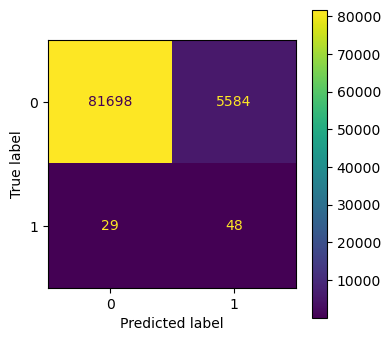

              precision    recall  f1-score   support

           0       1.00      0.94      0.97     87282
           1       0.01      0.62      0.02        77

    accuracy                           0.94     87359
   macro avg       0.50      0.78      0.49     87359
weighted avg       1.00      0.94      0.97     87359

                             cutoff-varying metrics                             
                               positive class: 1                                


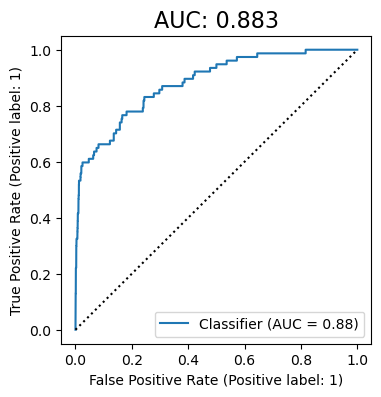


################################################################################

test metrics - cutoff = 0.50


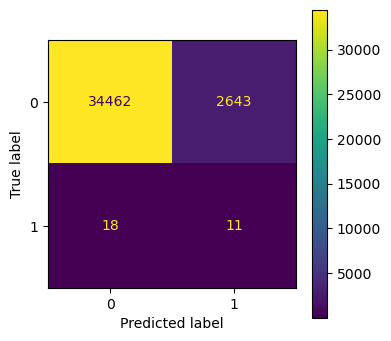

              precision    recall  f1-score   support

           0       1.00      0.93      0.96     37105
           1       0.00      0.38      0.01        29

    accuracy                           0.93     37134
   macro avg       0.50      0.65      0.49     37134
weighted avg       1.00      0.93      0.96     37134

                             cutoff-varying metrics                             
                               positive class: 1                                


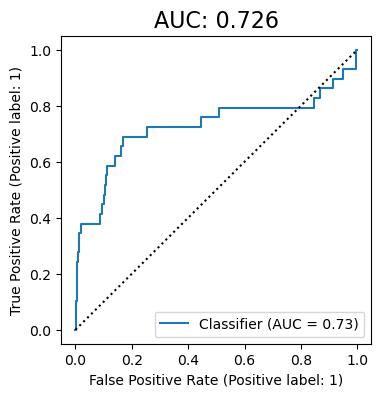

In [34]:
from sklearn.linear_model import LogisticRegression

logit_pipe = Pipeline([
    ("scaler", StandardScaler()),
    ("logit", LogisticRegression(class_weight="balanced"))
]).fit(X_train, y_train)

_ = clf_metrics_train_test(
    logit_pipe, X_train, y_train, X_test, y_test, cutoff=0.5,
    print_plot=True, plot_conf_matrix=True, print_cr=True,
    plot_prc=False, plot_roc=True, pos_label=1
)

#### Gradient Boosting

train metrics - cutoff = 0.50


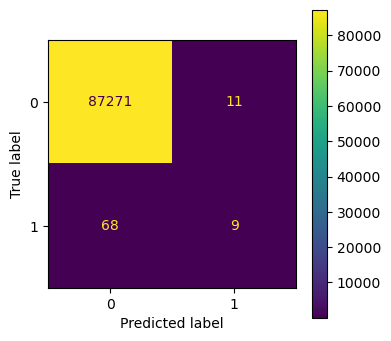

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     87282
           1       0.45      0.12      0.19        77

    accuracy                           1.00     87359
   macro avg       0.72      0.56      0.59     87359
weighted avg       1.00      1.00      1.00     87359

                             cutoff-varying metrics                             
                               positive class: 1                                


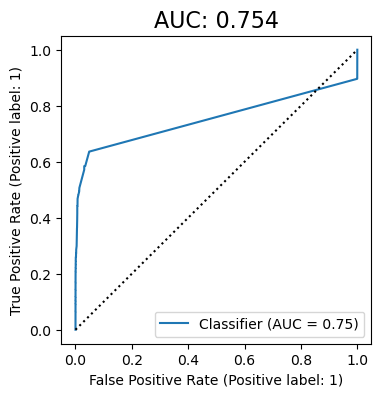


################################################################################

test metrics - cutoff = 0.50


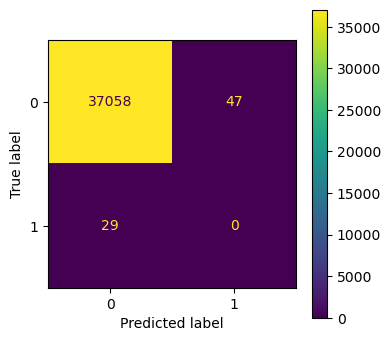

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     37105
           1       0.00      0.00      0.00        29

    accuracy                           1.00     37134
   macro avg       0.50      0.50      0.50     37134
weighted avg       1.00      1.00      1.00     37134

                             cutoff-varying metrics                             
                               positive class: 1                                


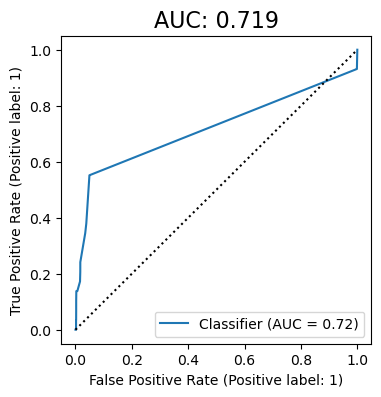

In [35]:
from sklearn.ensemble import GradientBoostingClassifier

gb_pipe = Pipeline([
    ("scaler", StandardScaler()),
    ("gb", GradientBoostingClassifier())
]).fit(X_train, y_train)

_ = clf_metrics_train_test(
    gb_pipe, X_train, y_train, X_test, y_test, cutoff=0.5, 
    print_plot=True, plot_conf_matrix=True, print_cr=True,
    plot_prc=False, plot_roc=True, pos_label=1
)

#### Adaboost

train metrics - cutoff = 0.50


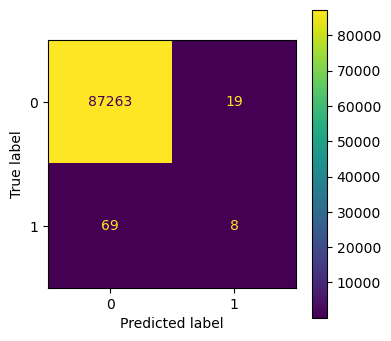

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     87282
           1       0.30      0.10      0.15        77

    accuracy                           1.00     87359
   macro avg       0.65      0.55      0.58     87359
weighted avg       1.00      1.00      1.00     87359

                             cutoff-varying metrics                             
                               positive class: 1                                


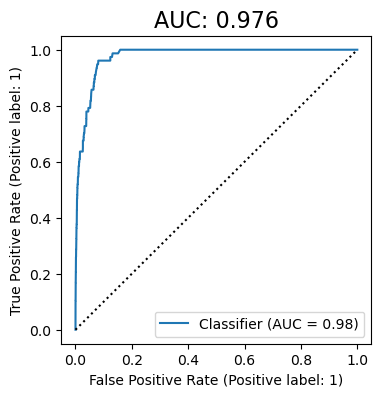


################################################################################

test metrics - cutoff = 0.50


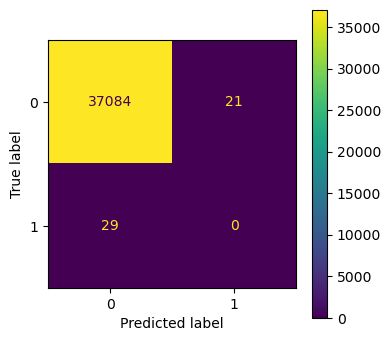

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     37105
           1       0.00      0.00      0.00        29

    accuracy                           1.00     37134
   macro avg       0.50      0.50      0.50     37134
weighted avg       1.00      1.00      1.00     37134

                             cutoff-varying metrics                             
                               positive class: 1                                


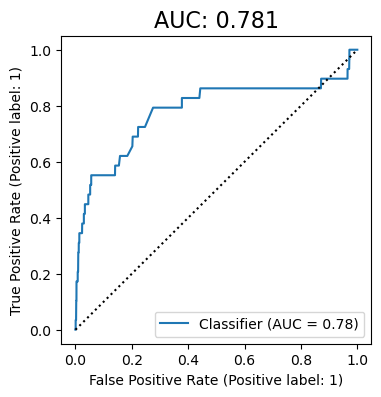

In [36]:
from sklearn.ensemble import AdaBoostClassifier

ada_pipe = Pipeline([
    ("scaler", StandardScaler()),
    ("ada", AdaBoostClassifier())
]).fit(X_train, y_train)

_ = clf_metrics_train_test(
    ada_pipe, X_train, y_train, X_test, y_test, cutoff=0.5, 
    print_plot=True, plot_conf_matrix=True, print_cr=True,
    plot_prc=False, plot_roc=True, pos_label=1
)

#### LGBM

[LightGBM] [Info] Number of positive: 77, number of negative: 87282
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002882 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1031
[LightGBM] [Info] Number of data points in the train set: 87359, number of used features: 9
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
train metrics - cutoff = 0.50


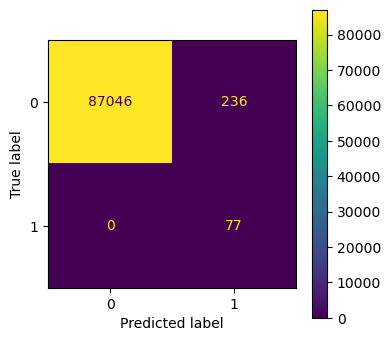

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     87282
           1       0.25      1.00      0.39        77

    accuracy                           1.00     87359
   macro avg       0.62      1.00      0.70     87359
weighted avg       1.00      1.00      1.00     87359

                             cutoff-varying metrics                             
                               positive class: 1                                


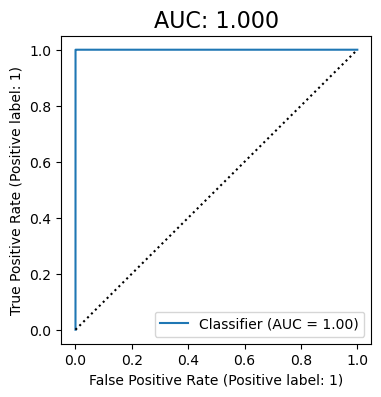


################################################################################

test metrics - cutoff = 0.50


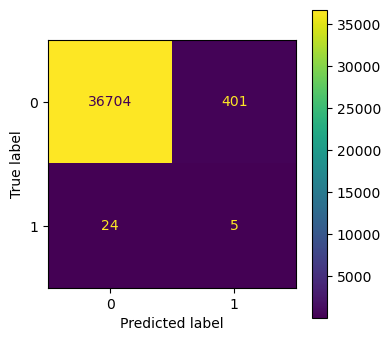

              precision    recall  f1-score   support

           0       1.00      0.99      0.99     37105
           1       0.01      0.17      0.02        29

    accuracy                           0.99     37134
   macro avg       0.51      0.58      0.51     37134
weighted avg       1.00      0.99      0.99     37134

                             cutoff-varying metrics                             
                               positive class: 1                                


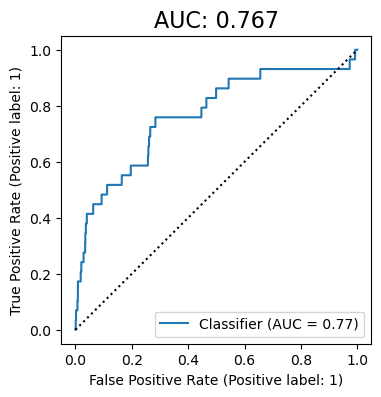

In [37]:
from lightgbm import LGBMClassifier

lgbm_pipe = Pipeline([
    ("scaler", StandardScaler()),
    ("lgbm", LGBMClassifier(class_weight="balanced"))  # colocando peso nas classes 
]).fit(X_train, y_train)

_ = clf_metrics_train_test(
    lgbm_pipe, X_train, y_train, X_test, y_test, cutoff=0.5, 
    print_plot=True, plot_conf_matrix=True, print_cr=True,
    plot_prc=False, plot_roc=True, pos_label=1
)

As avaliações não foram boas devido o desequilíbrio das classes do target.

Para melhorar o balanceamento, existem algumas técnicas:

- Subamostragem (Undersampling):
    - Random undersampling, cluster centroids
- Sobreamostragem (Oversampling):
    - Random oversampling, SMOTE
- Geração de Peso (Weighting):
    - Acabamos de fazer no LGBM e na regressão logística
- Entre outras com combinação de técnicas, métodos híbridos, dados sintéticos, etc.

**Usando o Random undersampling**

Aleatoriamente remove exemplos da classe majoritária até que o conjunto de dados estejam mais equilibrado

In [38]:
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline

#### Regressão Logística

train metrics - cutoff = 0.50


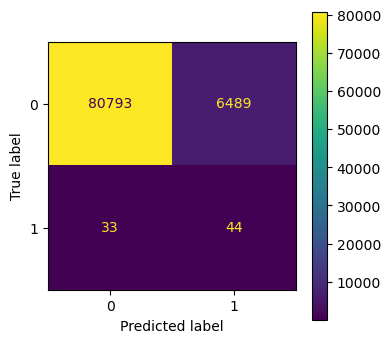

              precision    recall  f1-score   support

           0       1.00      0.93      0.96     87282
           1       0.01      0.57      0.01        77

    accuracy                           0.93     87359
   macro avg       0.50      0.75      0.49     87359
weighted avg       1.00      0.93      0.96     87359

                             cutoff-varying metrics                             
                               positive class: 1                                


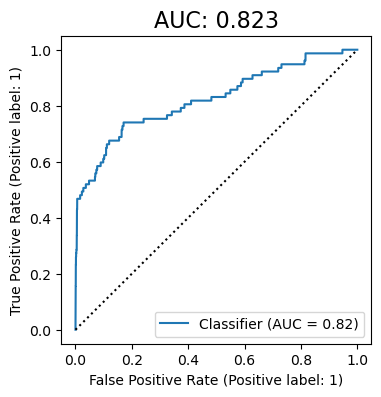


################################################################################

test metrics - cutoff = 0.50


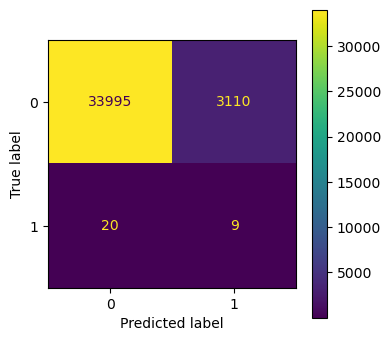

              precision    recall  f1-score   support

           0       1.00      0.92      0.96     37105
           1       0.00      0.31      0.01        29

    accuracy                           0.92     37134
   macro avg       0.50      0.61      0.48     37134
weighted avg       1.00      0.92      0.96     37134

                             cutoff-varying metrics                             
                               positive class: 1                                


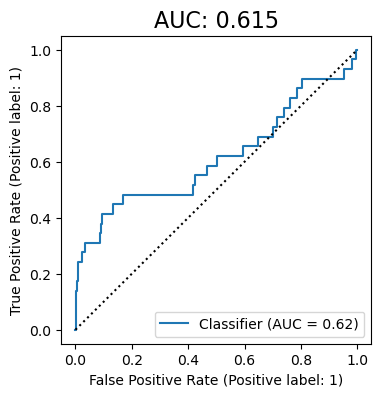

In [39]:
from sklearn.linear_model import LogisticRegression

logit_pipe = Pipeline([
    ("scaler", StandardScaler()),
    ("us", RandomUnderSampler()),
    ("logit", LogisticRegression())
]).fit(X_train, y_train)

_ = clf_metrics_train_test(
    logit_pipe, X_train, y_train, X_test, y_test, cutoff=0.5,
    print_plot=True, plot_conf_matrix=True, print_cr=True,
    plot_prc=False, plot_roc=True, pos_label=1
)

#### AdaBoost

train metrics - cutoff = 0.50


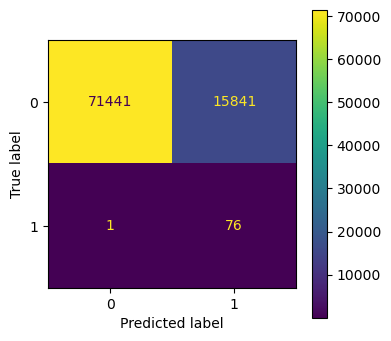

              precision    recall  f1-score   support

           0       1.00      0.82      0.90     87282
           1       0.00      0.99      0.01        77

    accuracy                           0.82     87359
   macro avg       0.50      0.90      0.45     87359
weighted avg       1.00      0.82      0.90     87359

                             cutoff-varying metrics                             
                               positive class: 1                                


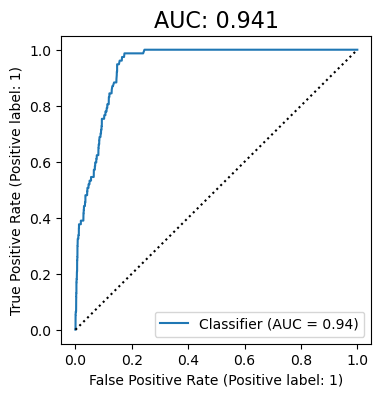


################################################################################

test metrics - cutoff = 0.50


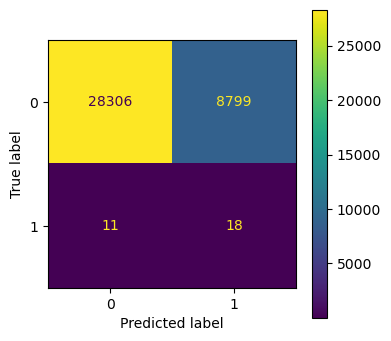

              precision    recall  f1-score   support

           0       1.00      0.76      0.87     37105
           1       0.00      0.62      0.00        29

    accuracy                           0.76     37134
   macro avg       0.50      0.69      0.43     37134
weighted avg       1.00      0.76      0.86     37134

                             cutoff-varying metrics                             
                               positive class: 1                                


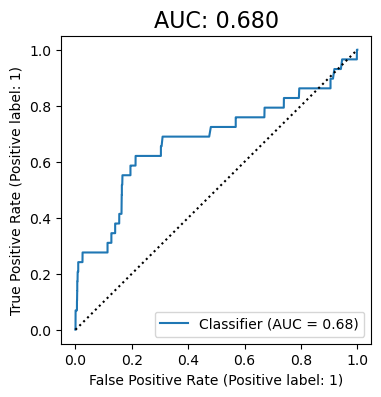

In [40]:
from sklearn.ensemble import AdaBoostClassifier

ada_pipe = Pipeline([
    ("scaler", StandardScaler()),
    ("us", RandomUnderSampler()),
    ("ada", AdaBoostClassifier())
]).fit(X_train, y_train)

_ = clf_metrics_train_test(
    ada_pipe, X_train, y_train, X_test, y_test, cutoff=0.5, 
    print_plot=True, plot_conf_matrix=True, print_cr=True,
    plot_prc=False, plot_roc=True, pos_label=1
)

#### LGBM

[LightGBM] [Info] Number of positive: 77, number of negative: 77
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000051 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 192
[LightGBM] [Info] Number of data points in the train set: 154, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain

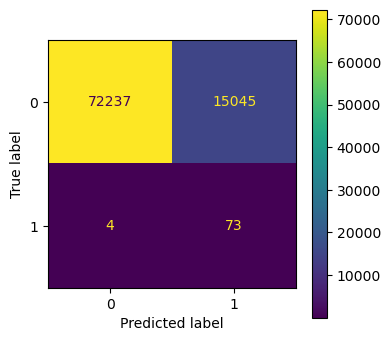

              precision    recall  f1-score   support

           0       1.00      0.83      0.91     87282
           1       0.00      0.95      0.01        77

    accuracy                           0.83     87359
   macro avg       0.50      0.89      0.46     87359
weighted avg       1.00      0.83      0.90     87359

                             cutoff-varying metrics                             
                               positive class: 1                                


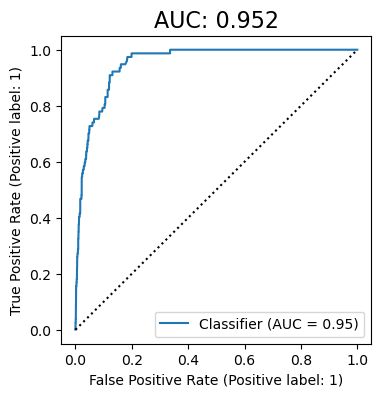


################################################################################

test metrics - cutoff = 0.50


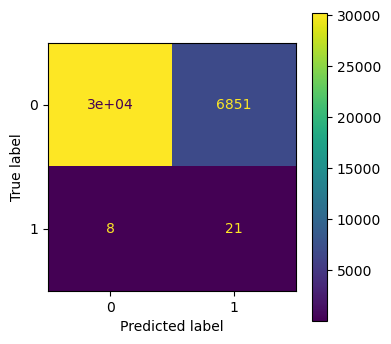

              precision    recall  f1-score   support

           0       1.00      0.82      0.90     37105
           1       0.00      0.72      0.01        29

    accuracy                           0.82     37134
   macro avg       0.50      0.77      0.45     37134
weighted avg       1.00      0.82      0.90     37134

                             cutoff-varying metrics                             
                               positive class: 1                                


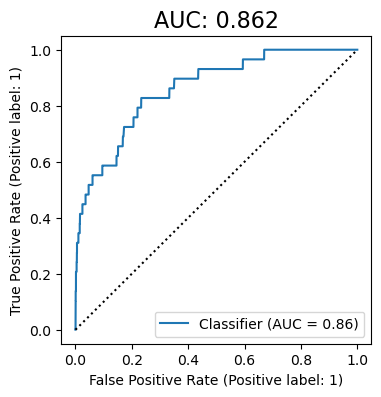

In [41]:
from lightgbm import LGBMClassifier

lgbm_pipe = Pipeline([
    ("scaler", StandardScaler()),
    ("us", RandomUnderSampler()),
    ("lgbm", LGBMClassifier())
]).fit(X_train, y_train)

_ = clf_metrics_train_test(
    lgbm_pipe, X_train, y_train, X_test, y_test, cutoff=0.5, 
    print_plot=True, plot_conf_matrix=True, print_cr=True,
    plot_prc=False, plot_roc=True, pos_label=1
)

Obs.: Os avisos significam que o algoritmo LightGBM não conseguiu encontrar uma maneira eficaz de dividir os dados em um determinado nó da árvore de decisão durante o treinamento

Ainda não chegamos em um modelo bom. 
Lembrando que temos classe desbalanceada e, pela natureza do problema, podemos ter um alto falso positivo mas precisamos ter um valor baixo de falso negativo. 

Olhando os estimadores acima, vou escolher o LGBM para otimizar os hiperparâmetros pois apresentou o melhor maior Recall nos dados de teste

#### Otimização de hiper parâmetros


Para isso, tenho algumas opções

- Busca em Grade (Grid Search): Explora exaustivamente um espaço pré-definido de hiperparâmetros.
- Busca Aleatória (Random Search): Amostra aleatoriamente um subconjunto do espaço de hiperparâmetros, sendo mais eficiente computacionalmente.
- Otimização Bayesiana: Utiliza métodos probabilísticos para modelar a função objetivo e escolher os próximos conjuntos de hiperparâmetros.
- Otimização por Surrogado: Constrói um modelo aproximado da função objetivo para sugerir conjuntos promissores de hiperparâmetros.
- Otimização Genética: Modelada a partir da evolução biológica, usa conceitos de seleção natural, cruzamento e mutação.
- Otimização por Gradiente: Utiliza métodos de otimização baseados em gradiente, como gradient descent, exigindo derivadas da função objetivo em relação aos hiperparâmetros.

A técnica mais simples é a grid search porém é muito demorada. Vou usar a Random Search para encontrar hiperparâmetros melhores para o LGBM

Para a otimização, eu poderia escolher métricas recall/sensibilidade (que mede a capacidade do modelo em identificar corretamente todos os exemplos positivos), f1, acurácia do modelo porém o objetivo é minimizar os custos de processo. Para isso usamos uma função personalizada de minimização de custo segundo uma regra.

Considerando que há custo de falha e manutenção, a otimização é feita em cima da minimização do custo.

- Custo de falha é 1 quando o modelo não detecta a falha que vai ocorrer, ou seja, falso negativo.
- Custo de manutenção é 0.5 quando o modelo identificou a falha mas ela não iria acontecer, ou seja, falso positivo.




In [42]:
# Apenas relembrando como cria função personalizada para avaliar o modelo

from sklearn.metrics import precision_recall_fscore_support

def custom_cost(y_true, y_pred):
    cost_false_positive = 0.5  # Custo a falsos positivos
    cost_false_negative = 1.0  # Custo falsos negativos

    precision, recall, _, _ = precision_recall_fscore_support(y_true, y_pred, average='binary')

    total_cost = cost_false_positive * (1 - precision) + cost_false_negative * (1 - recall)

    return total_cost

# Exemplo de uso:
y_true = [0, 0, 1, 1, 1, 1]
y_pred = [0, 0, 1, 1, 0, 1]

cost = custom_cost(y_true, y_pred)
print(f'Custo Total: {cost}')

Custo Total: 0.25


Aplicando essa função de custo para ser minimizada na otimização com o LGBM

In [45]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform

class CostOptimizedPredictor(BaseEstimator, TransformerMixin):
    def __init__(self, base_estimator):
        self.base_estimator = base_estimator

    def fit(self, X, y):
        self.base_estimator.fit(X, y)
        return self

    def predict(self, X):
        return self.base_estimator.predict(X)

    def predict_proba(self, X):
        return self.base_estimator.predict_proba(X)

    def custom_cost(self, y_true, y_pred):
        cost_false_positive = 0.5
        cost_false_negative = 1.0

        tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()

        total_cost = cost_false_positive * fp + cost_false_negative * fn

        return total_cost

    def score(self, X, y):
        y_pred = self.predict(X)
        cost = self.custom_cost(y, y_pred)
        return -cost  # Inverta o sinal para minimizar o custo

# Parâmetros e suas faixas de valores
param_dist = {
    'custom_predictor__base_estimator__num_leaves': [10, 20, 30, 40, 50],
    'custom_predictor__base_estimator__learning_rate': uniform(loc=0.001, scale=0.1),
    'custom_predictor__base_estimator__n_estimators': [50, 100, 200, 300],
    'custom_predictor__base_estimator__class_weight': ['balanced', None],
}

pipeline = Pipeline([
    ("scaler", StandardScaler()),
    ("us", RandomUnderSampler()),
    ("custom_predictor", CostOptimizedPredictor(base_estimator=LGBMClassifier()))
])

random_search_lgbm = RandomizedSearchCV(
    estimator=pipeline,
    param_distributions=param_dist,
    n_iter=10,  
    scoring=make_scorer(CostOptimizedPredictor(base_estimator=LGBMClassifier()).score, greater_is_better=False),  # Minimizar o custo do processo
    cv=5  
)

random_search_lgbm.fit(X_train, y_train)

print("Melhores Parâmetros:", random_search_lgbm.best_params_)

best_model_lgbm = random_search_lgbm.best_estimator_

[LightGBM] [Info] Number of positive: 61, number of negative: 61
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000055 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 155
[LightGBM] [Info] Number of data points in the train set: 122, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain

C:\Users\RMM\miniconda3\envs\ada\Lib\site-packages\sklearn\model_selection\_validation.py:821: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\RMM\miniconda3\envs\ada\Lib\site-packages\sklearn\model_selection\_validation.py", line 810, in _score
    scores = scorer(estimator, X_test, y_test)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\RMM\miniconda3\envs\ada\Lib\site-packages\sklearn\metrics\_scorer.py", line 266, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\RMM\miniconda3\envs\ada\Lib\site-packages\sklearn\metrics\_scorer.py", line 355, in _score
    return self._sign * self._score_func(y_true, y_pred, **scoring_kwargs)
                        ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

C:\Users\RMM\miniconda3\envs\ada\Lib\site-packages\sklearn\model_selection\_validation.py:821: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\RMM\miniconda3\envs\ada\Lib\site-packages\sklearn\model_selection\_validation.py", line 810, in _score
    scores = scorer(estimator, X_test, y_test)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\RMM\miniconda3\envs\ada\Lib\site-packages\sklearn\metrics\_scorer.py", line 266, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\RMM\miniconda3\envs\ada\Lib\site-packages\sklearn\metrics\_scorer.py", line 355, in _score
    return self._sign * self._score_func(y_true, y_pred, **scoring_kwargs)
                        ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

[LightGBM] [Info] Number of positive: 67, number of negative: 67
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000082 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 166
[LightGBM] [Info] Number of data points in the train set: 134, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain

C:\Users\RMM\miniconda3\envs\ada\Lib\site-packages\sklearn\model_selection\_validation.py:821: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\RMM\miniconda3\envs\ada\Lib\site-packages\sklearn\model_selection\_validation.py", line 810, in _score
    scores = scorer(estimator, X_test, y_test)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\RMM\miniconda3\envs\ada\Lib\site-packages\sklearn\metrics\_scorer.py", line 266, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\RMM\miniconda3\envs\ada\Lib\site-packages\sklearn\metrics\_scorer.py", line 355, in _score
    return self._sign * self._score_func(y_true, y_pred, **scoring_kwargs)
                        ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

[LightGBM] [Info] Number of positive: 61, number of negative: 61
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000050 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 153
[LightGBM] [Info] Number of data points in the train set: 122, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain

C:\Users\RMM\miniconda3\envs\ada\Lib\site-packages\sklearn\model_selection\_validation.py:821: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\RMM\miniconda3\envs\ada\Lib\site-packages\sklearn\model_selection\_validation.py", line 810, in _score
    scores = scorer(estimator, X_test, y_test)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\RMM\miniconda3\envs\ada\Lib\site-packages\sklearn\metrics\_scorer.py", line 266, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\RMM\miniconda3\envs\ada\Lib\site-packages\sklearn\metrics\_scorer.py", line 355, in _score
    return self._sign * self._score_func(y_true, y_pred, **scoring_kwargs)
                        ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

[LightGBM] [Info] Number of positive: 67, number of negative: 67
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000043 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 169
[LightGBM] [Info] Number of data points in the train set: 134, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain

[LightGBM] [Info] Number of positive: 60, number of negative: 60
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000065 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 154
[LightGBM] [Info] Number of data points in the train set: 120, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain

C:\Users\RMM\miniconda3\envs\ada\Lib\site-packages\sklearn\model_selection\_validation.py:821: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\RMM\miniconda3\envs\ada\Lib\site-packages\sklearn\model_selection\_validation.py", line 810, in _score
    scores = scorer(estimator, X_test, y_test)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\RMM\miniconda3\envs\ada\Lib\site-packages\sklearn\metrics\_scorer.py", line 266, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\RMM\miniconda3\envs\ada\Lib\site-packages\sklearn\metrics\_scorer.py", line 355, in _score
    return self._sign * self._score_func(y_true, y_pred, **scoring_kwargs)
                        ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

[LightGBM] [Info] Number of positive: 50, number of negative: 50
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000055 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 139
[LightGBM] [Info] Number of data points in the train set: 100, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain

C:\Users\RMM\miniconda3\envs\ada\Lib\site-packages\sklearn\model_selection\_validation.py:821: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\RMM\miniconda3\envs\ada\Lib\site-packages\sklearn\model_selection\_validation.py", line 810, in _score
    scores = scorer(estimator, X_test, y_test)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\RMM\miniconda3\envs\ada\Lib\site-packages\sklearn\metrics\_scorer.py", line 266, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\RMM\miniconda3\envs\ada\Lib\site-packages\sklearn\metrics\_scorer.py", line 355, in _score
    return self._sign * self._score_func(y_true, y_pred, **scoring_kwargs)
                        ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

[LightGBM] [Info] Number of positive: 70, number of negative: 70
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000048 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 179
[LightGBM] [Info] Number of data points in the train set: 140, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain

C:\Users\RMM\miniconda3\envs\ada\Lib\site-packages\sklearn\model_selection\_validation.py:821: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\RMM\miniconda3\envs\ada\Lib\site-packages\sklearn\model_selection\_validation.py", line 810, in _score
    scores = scorer(estimator, X_test, y_test)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\RMM\miniconda3\envs\ada\Lib\site-packages\sklearn\metrics\_scorer.py", line 266, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\RMM\miniconda3\envs\ada\Lib\site-packages\sklearn\metrics\_scorer.py", line 355, in _score
    return self._sign * self._score_func(y_true, y_pred, **scoring_kwargs)
                        ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

C:\Users\RMM\miniconda3\envs\ada\Lib\site-packages\sklearn\model_selection\_validation.py:821: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\RMM\miniconda3\envs\ada\Lib\site-packages\sklearn\model_selection\_validation.py", line 810, in _score
    scores = scorer(estimator, X_test, y_test)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\RMM\miniconda3\envs\ada\Lib\site-packages\sklearn\metrics\_scorer.py", line 266, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\RMM\miniconda3\envs\ada\Lib\site-packages\sklearn\metrics\_scorer.py", line 355, in _score
    return self._sign * self._score_func(y_true, y_pred, **scoring_kwargs)
                        ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

[LightGBM] [Info] Number of positive: 70, number of negative: 70
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000084 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 179
[LightGBM] [Info] Number of data points in the train set: 140, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain

C:\Users\RMM\miniconda3\envs\ada\Lib\site-packages\sklearn\model_selection\_validation.py:821: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\RMM\miniconda3\envs\ada\Lib\site-packages\sklearn\model_selection\_validation.py", line 810, in _score
    scores = scorer(estimator, X_test, y_test)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\RMM\miniconda3\envs\ada\Lib\site-packages\sklearn\metrics\_scorer.py", line 266, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\RMM\miniconda3\envs\ada\Lib\site-packages\sklearn\metrics\_scorer.py", line 355, in _score
    return self._sign * self._score_func(y_true, y_pred, **scoring_kwargs)
                        ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

[LightGBM] [Info] Number of positive: 50, number of negative: 50
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000053 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 137
[LightGBM] [Info] Number of data points in the train set: 100, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain

C:\Users\RMM\miniconda3\envs\ada\Lib\site-packages\sklearn\model_selection\_validation.py:821: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\RMM\miniconda3\envs\ada\Lib\site-packages\sklearn\model_selection\_validation.py", line 810, in _score
    scores = scorer(estimator, X_test, y_test)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\RMM\miniconda3\envs\ada\Lib\site-packages\sklearn\metrics\_scorer.py", line 266, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\RMM\miniconda3\envs\ada\Lib\site-packages\sklearn\metrics\_scorer.py", line 355, in _score
    return self._sign * self._score_func(y_true, y_pred, **scoring_kwargs)
                        ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

[LightGBM] [Info] Number of positive: 60, number of negative: 60
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000077 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 151
[LightGBM] [Info] Number of data points in the train set: 120, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain

C:\Users\RMM\miniconda3\envs\ada\Lib\site-packages\sklearn\model_selection\_validation.py:821: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\RMM\miniconda3\envs\ada\Lib\site-packages\sklearn\model_selection\_validation.py", line 810, in _score
    scores = scorer(estimator, X_test, y_test)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\RMM\miniconda3\envs\ada\Lib\site-packages\sklearn\metrics\_scorer.py", line 266, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\RMM\miniconda3\envs\ada\Lib\site-packages\sklearn\metrics\_scorer.py", line 355, in _score
    return self._sign * self._score_func(y_true, y_pred, **scoring_kwargs)
                        ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

[LightGBM] [Info] Number of positive: 67, number of negative: 67
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000088 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 168
[LightGBM] [Info] Number of data points in the train set: 134, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain

C:\Users\RMM\miniconda3\envs\ada\Lib\site-packages\sklearn\model_selection\_validation.py:821: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\RMM\miniconda3\envs\ada\Lib\site-packages\sklearn\model_selection\_validation.py", line 810, in _score
    scores = scorer(estimator, X_test, y_test)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\RMM\miniconda3\envs\ada\Lib\site-packages\sklearn\metrics\_scorer.py", line 266, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\RMM\miniconda3\envs\ada\Lib\site-packages\sklearn\metrics\_scorer.py", line 355, in _score
    return self._sign * self._score_func(y_true, y_pred, **scoring_kwargs)
                        ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

[LightGBM] [Info] Number of positive: 61, number of negative: 61
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000050 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 152
[LightGBM] [Info] Number of data points in the train set: 122, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain

C:\Users\RMM\miniconda3\envs\ada\Lib\site-packages\sklearn\model_selection\_validation.py:821: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\RMM\miniconda3\envs\ada\Lib\site-packages\sklearn\model_selection\_validation.py", line 810, in _score
    scores = scorer(estimator, X_test, y_test)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\RMM\miniconda3\envs\ada\Lib\site-packages\sklearn\metrics\_scorer.py", line 266, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\RMM\miniconda3\envs\ada\Lib\site-packages\sklearn\metrics\_scorer.py", line 355, in _score
    return self._sign * self._score_func(y_true, y_pred, **scoring_kwargs)
                        ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

[LightGBM] [Info] Number of positive: 50, number of negative: 50
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000056 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 141
[LightGBM] [Info] Number of data points in the train set: 100, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain

[LightGBM] [Info] Number of positive: 60, number of negative: 60
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000114 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 152
[LightGBM] [Info] Number of data points in the train set: 120, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain

C:\Users\RMM\miniconda3\envs\ada\Lib\site-packages\sklearn\model_selection\_validation.py:821: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\RMM\miniconda3\envs\ada\Lib\site-packages\sklearn\model_selection\_validation.py", line 810, in _score
    scores = scorer(estimator, X_test, y_test)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\RMM\miniconda3\envs\ada\Lib\site-packages\sklearn\metrics\_scorer.py", line 266, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\RMM\miniconda3\envs\ada\Lib\site-packages\sklearn\metrics\_scorer.py", line 355, in _score
    return self._sign * self._score_func(y_true, y_pred, **scoring_kwargs)
                        ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

[LightGBM] [Info] Number of positive: 67, number of negative: 67
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000054 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 168
[LightGBM] [Info] Number of data points in the train set: 134, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain

C:\Users\RMM\miniconda3\envs\ada\Lib\site-packages\sklearn\model_selection\_validation.py:821: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\RMM\miniconda3\envs\ada\Lib\site-packages\sklearn\model_selection\_validation.py", line 810, in _score
    scores = scorer(estimator, X_test, y_test)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\RMM\miniconda3\envs\ada\Lib\site-packages\sklearn\metrics\_scorer.py", line 266, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\RMM\miniconda3\envs\ada\Lib\site-packages\sklearn\metrics\_scorer.py", line 355, in _score
    return self._sign * self._score_func(y_true, y_pred, **scoring_kwargs)
                        ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

[LightGBM] [Info] Number of positive: 61, number of negative: 61
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000051 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 155
[LightGBM] [Info] Number of data points in the train set: 122, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain

C:\Users\RMM\miniconda3\envs\ada\Lib\site-packages\sklearn\model_selection\_validation.py:821: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\RMM\miniconda3\envs\ada\Lib\site-packages\sklearn\model_selection\_validation.py", line 810, in _score
    scores = scorer(estimator, X_test, y_test)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\RMM\miniconda3\envs\ada\Lib\site-packages\sklearn\metrics\_scorer.py", line 266, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\RMM\miniconda3\envs\ada\Lib\site-packages\sklearn\metrics\_scorer.py", line 355, in _score
    return self._sign * self._score_func(y_true, y_pred, **scoring_kwargs)
                        ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

[LightGBM] [Info] Number of positive: 67, number of negative: 67
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000062 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 168
[LightGBM] [Info] Number of data points in the train set: 134, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain

C:\Users\RMM\miniconda3\envs\ada\Lib\site-packages\sklearn\model_selection\_validation.py:821: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\RMM\miniconda3\envs\ada\Lib\site-packages\sklearn\model_selection\_validation.py", line 810, in _score
    scores = scorer(estimator, X_test, y_test)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\RMM\miniconda3\envs\ada\Lib\site-packages\sklearn\metrics\_scorer.py", line 266, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\RMM\miniconda3\envs\ada\Lib\site-packages\sklearn\metrics\_scorer.py", line 355, in _score
    return self._sign * self._score_func(y_true, y_pred, **scoring_kwargs)
                        ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

[LightGBM] [Info] Number of positive: 61, number of negative: 61
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000054 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 156
[LightGBM] [Info] Number of data points in the train set: 122, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain

C:\Users\RMM\miniconda3\envs\ada\Lib\site-packages\sklearn\model_selection\_validation.py:821: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\RMM\miniconda3\envs\ada\Lib\site-packages\sklearn\model_selection\_validation.py", line 810, in _score
    scores = scorer(estimator, X_test, y_test)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\RMM\miniconda3\envs\ada\Lib\site-packages\sklearn\metrics\_scorer.py", line 266, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\RMM\miniconda3\envs\ada\Lib\site-packages\sklearn\metrics\_scorer.py", line 355, in _score
    return self._sign * self._score_func(y_true, y_pred, **scoring_kwargs)
                        ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

[LightGBM] [Info] Number of positive: 67, number of negative: 67
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000088 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 169
[LightGBM] [Info] Number of data points in the train set: 134, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain

Encontrado os melhores parâmetros, vamos calcular o custo:

In [47]:
from lightgbm import LGBMClassifier
from sklearn.metrics import confusion_matrix

# Obter os melhores parâmetros da otimização, treinar o modelo, fazer a predição
best_params = random_search_lgbm.best_params_

print(f'Esses são os melhores parâmetros: {best_params}\n')

best_model = LGBMClassifier(**best_params)

best_model.fit(X_train, y_train)

y_pred = best_model.predict(X_test)

# Calcular a matriz de confusão
matriz_confusao = confusion_matrix(y_test, y_pred)

print(f'\nEssa é a matriz de confusão: \n{matriz_confusao}')

# Calcular o custo com base na matriz de confusão
custo = matriz_confusao[1, 0] * 1 + matriz_confusao[0, 1] * 0.5

print(f"\nCusto com melhores parâmetros: {custo}")

Esses são os melhores parâmetros: {'custom_predictor__base_estimator__class_weight': None, 'custom_predictor__base_estimator__learning_rate': 0.04567594271948482, 'custom_predictor__base_estimator__n_estimators': 300, 'custom_predictor__base_estimator__num_leaves': 10}

[LightGBM] [Warning] Unknown parameter: custom_predictor__base_estimator__learning_rate
[LightGBM] [Warning] Unknown parameter: custom_predictor__base_estimator__n_estimators
[LightGBM] [Warning] Unknown parameter: custom_predictor__base_estimator__num_leaves
[LightGBM] [Warning] Unknown parameter: custom_predictor__base_estimator__learning_rate
[LightGBM] [Warning] Unknown parameter: custom_predictor__base_estimator__n_estimators
[LightGBM] [Warning] Unknown parameter: custom_predictor__base_estimator__num_leaves
[LightGBM] [Info] Number of positive: 77, number of negative: 87282
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002438 seconds.
You can set `force_row_wise=true` to 

Interessante que os verdadeiros negativos tiveram que diminuir (ou seja, acertar a falha) para minimizar o custo. Faz sentido pois se não há custo quando se acerta, então temos que procurar o menor equilíbrio entre FN e FP mesmo as custas do TP.


Isso só foi possível quando troquei a otimização do modelo para a função personalizada.

Obs.: 
- Poderia aplicar um framework de otimização de hiperparâmetros automatizado, como por exemplo o Optuna
- Eu poderia usar o PyCaret (biblioteca de AutoML) para simplificar o processo de construção, avaliação e implantação de modelos
- Poderia usar outras técnicas de balanceamento de classes
- Poderia usar outros valores de cutoff do modelo

Pode parecer um pouco bagunçado mas essa foi minha linha de pensamento e desenvolvimento em pouco tempo.

# Conclusão

Otimizando a Manutenção Preditiva para Redução de Custos

O desafio foi desenvolver um modelo preditivo robusto para prever a probabilidade de falhas em dispositivos, visando otimizar os custos associados à manutenção. A probabilidade de falha é 0.085%, para modelos de machine learning um valor muito baixo. de A abordagem foi abrangente, desde o pré-processamento de dados até a otimização de hiperparâmetros, utilizando técnicas avançadas de machine learning.

O modelo final foi o LightGBM e seu desempenho foi aprimorado com a otimização com Random Search. A utilização de undersampling para abordar o desbalanceamento de classes contribuiu para melhorar a capacidade do modelo em lidar com casos de falhas.

Ao incorporar uma métrica personalizada que considera os custos específicos do processo, consegui minimizar efetivamente o custo total, atingindo um equilíbrio entre falsos positivos e falsos negativos.

Esta análise demonstra que a implementação de técnicas avançadas de machine learning, aliada a uma métrica personalizada, pode oferecer uma solução eficaz para otimizar processos de manutenção preditiva, proporcionando benefícios em termos de redução de custos.

<div style="background-color: lightblue; padding: 10px;">
    <h2> Gracias  <br>
        <h5>Renata Martins Marchese
</div>